## This notebook for the last part of the peer-graded assignment of week 5 of Applied Data Science Capstone

In [1]:
#mport the necessary libraries
import pandas as pd
import numpy as np
import requests

from math import sin, cos, sqrt, acos, asin, radians, degrees
import time
import copy
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn import preprocessing
from sklearn.metrics import f1_score
from scipy.optimize import minimize
from scipy.optimize import least_squares

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.49   | 

# 0. Import of the libraries

In [2]:
#Initialize the variables to access Foursquare API

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20190831' # Foursquare API version

LIMIT = 100 #Number of venues retourned per explore request
nagoya_radius = 8000 #Estimated radius of Nagoya (overestimation)

french_restaurant_id='4bf58dd8d48988d10c941735'#French Restaurants
subway_id = '4bf58dd8d48988d1fd931735' #Metro Station
train_station_id = '4bf58dd8d48988d129951735' #Train Station

art_enter_catid = '4d4b7104d754a06370d81259' #Arts & Entertainment
food_catid = '4d4b7105d754a06374d81259' #Food
night_life_catid = '4d4b7105d754a06376d81259' #Nightlife Spot
shop_catid = '4d4b7105d754a06378d81259'#Shop & Service
transport_catid = '4d4b7105d754a06379d81259'#Travel & Transport
education_catid = '4d4b7105d754a06372d81259'#College & University
recreation_catit = '4d4b7105d754a06377d81259' #Outdoors & Recreation
professional_catid = '4d4b7105d754a06375d81259'  #Professional & Other Places
residence_catid = '4e67e38e036454776db1fb3a' #Residence

longstay_catid = ','.join([education_catid, professional_catid, residence_catid])
shortstay_catid = ','.join([art_enter_catid, night_life_catid])

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


# 1. Initialization of the constants and variables used for the notebook

In [3]:
# #Get the coordinates of Nagoya
# address = 'Nagoya'
# geolocator = Nominatim(user_agent="ny_explorer")
# nagoya_location = geolocator.geocode(address)
# nagoya_latitude = nagoya_location.latitude
# nagoya_longitude = nagoya_location.longitude
# print('The geograpical coordinate of Nagoya are {}, {}.'.format(nagoya_latitude, nagoya_longitude))
nagoya_latitude = 35.1851045 
nagoya_longitude = 136.8998438

In [4]:
#Function to get the the list of venues in Nagoya belonging to a certain category  
def explore_venue_foursquare(cat, lat, lng, radius):

    venues_list=[]

    name = 'Nagoya'
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT,
        cat)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        v['venue']['id'],
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

# 2. Collection of the data from Foursquare 

In [5]:
# french_venues = explore_venue_foursquare(french_restaurant_id, nagoya_latitude, nagoya_longitude, nagoya_radius)
# print(french_venues.shape)

# #Some venues may not be catgorized as French Restaurant because the first category is something else, like bakery
# #For our studies, let's change all category to French Restaurant
# #french_venues['Venue Category'] = 'French Restaurant'

# #write the data as backup
# french_venues.to_csv(r'data/french_restaurants.csv', index = False)

In [6]:
#read the list of French restaurants. This dataframe was previously obtained thanks to the cell just above
french_venues = pd.read_csv("data/french_restaurants.csv") 

In [7]:
# show all French restaurants in Nagoya to map
# the blue circle shows where French restaurants were found

# the red circle shows where the area 'AFR', the area is centered around the French restaurants
# the red circle center and radius was found empirically 

avg_frr_lat = 35.163231
avg_frr_lgt = 136.924910
avg_frr_radius = 6000

map_nagoya = folium.Map(location=[nagoya_latitude, nagoya_longitude], zoom_start=10)

for name, lat, lgt in zip(french_venues['Venue'], french_venues['Venue Latitude'], french_venues['Venue Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nagoya) 
folium.Circle([nagoya_latitude, nagoya_longitude], 
              nagoya_radius, 
              popup=None, 
              color='blue',
              tooltip=None).add_to(map_nagoya)
folium.Circle([avg_frr_lat, avg_frr_lgt], 
              avg_frr_radius, 
              popup=None, 
              color='red',
              tooltip=None).add_to(map_nagoya)

map_nagoya

In [8]:
#show the French restaurants along with the estimated center
avg_frr_lat = 35.163231
avg_frr_lgt = 136.924910
avg_frr_radius = 6000

# show all French restaurants in Nagoya to map with the circle
map_newyork_venues = folium.Map(location=[nagoya_latitude, nagoya_longitude], zoom_start=10)

for name, lat, lgt in zip(french_venues['Venue'], french_venues['Venue Latitude'], french_venues['Venue Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_venues) 
folium.Circle([avg_frr_lat, avg_frr_lgt], 
              avg_frr_radius, 
              popup=None, 
              color='red',
              tooltip=None).add_to(map_newyork_venues)

map_newyork_venues

In [9]:
#convert latitude/longitude to Cartesian coordinates where the origin in the center of French restaurants
#The formula is derived from the Equirectangular approximation
#using this website as reference:
#http://www.movable-type.co.uk/scripts/latlong.html
def convert_lat_lgt_to_cart(lat,lgt):
    # approximate radius of earth in m
    R = 6373.0 * 1000.
    
    lat = radians(lat)
    lgt = radians(lgt)
    lat0 = radians(avg_frr_lat)
    lgt0 = radians(avg_frr_lgt)
    
    dlat = lat - lat0
    dlgt = lgt - lgt0
    
    x = R * dlgt * cos(lat0)
    y = R * dlat
    
    return x,y

In [10]:
#the inverse function of the above function
def convert_cart_to_lat_lgt(x,y):
    # approximate radius of earth in m
    R = 6373.0 * 1000.
    
    lat0 = radians(avg_frr_lat)
    lgt0 = radians(avg_frr_lgt)
    
    dlat = y / R
    lat = dlat + lat0
    dlgt = x / cos(lat0) / R
    lgt = dlgt + lgt0
    
    return degrees(lat),degrees(lgt)

In [11]:
#Get the distance in meters between two points on Earth using latitude and longitude
#The distance calculated this way is more accurate
def convert_lat_lgt_to_meters(lat1, lat2, lgt1, lgt2):
    # approximate radius of earth in m
    R = 6373.0 *1000. 

    lat1 = radians(lat1)
    lgt1 = radians(lgt1)
    lat2 = radians(lat2)
    lgt2 = radians(lgt2)

    dlgt = lgt2 - lgt1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlgt / 2)**2
    
    distance = 2 * R * asin(a**0.5)

    return distance

In [12]:
#We will approximately divide the area around the origin of French restaurants in 30*30 squares
#The area divided is approximately a circle whose radius is 6500 meters. 

lat_ex, lgt_ex = convert_cart_to_lat_lgt(6500,6500)
print(lat_ex, lgt_ex)
length = ((lat_ex-avg_frr_lat)**2 + (lgt_ex-avg_frr_lgt)**2)**0.5
length = length / 2**0.5

print(length)

div = 30
nbsubarea = div ** 2
radius_grid = 330

min_latitude = avg_frr_lat - length
max_latitude = avg_frr_lat + length
min_longitude = avg_frr_lgt - length
max_longitude = avg_frr_lgt + length

list_lat = np.linspace(min_latitude,max_latitude,div)
list_lgt = np.linspace(min_longitude,max_longitude,div)
xv,yv = np.meshgrid(list_lat, list_lgt)

part_serie = []
lat_serie = []
lgt_serie = []
x_serie = []
y_serie = []

column_1 = [str(i) for i in range(1,nbsubarea + 1)]
column_2 = [xv[i,j] for i in range(div) for j in range(div)]
column_3 = [yv[i,j] for i in range(div) for j in range(div)]

nagoya_grid = []

for i in range(nbsubarea):
    part = column_1[i]
    lat = column_2[i]
    lgt = column_3[i]
    x, y = convert_lat_lgt_to_cart(lat, lgt)
    nagoya_grid.append([part, lat, lgt, x, y])

35.22166855952221 136.99639197226492
0.06528637193852888


In [13]:
# We check we divided correctly the area
# create map of Nagoya using latitude and longitude values with the radius of each area
map_newyork = folium.Map(location=[avg_frr_lat, avg_frr_lgt], zoom_start=10)

# add markers to map
# we limit the number of circles to 300 because too many cicles make my browser crash
limit_aff = 99999
counter = 0

for data in nagoya_grid:
    part = data[0]
    lat = data[1]
    lgt = data[2]
    label = '{}'.format(part)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 
    folium.Circle([lat, lgt], 
                  radius_grid, 
                  popup=None, 
                  tooltip=None).add_to(map_newyork)
    counter += 1 
    if counter> limit_aff:
        break
    
folium.Circle([avg_frr_lat, avg_frr_lgt], 
          avg_frr_radius, 
          popup=None, 
          color='red',
          tooltip=None).add_to(map_newyork)
    
#map_newyork

In [14]:
#Get the list of venues for each points belonging to a specific category
def all_venues_in_grid_cat(grid_pd, radius, cat):
    
    venues_list=[]
    
    for data in nagoya_grid:   
        nb_error = 0
        part = data[0]
        lat = data[1]
        lgt = data[2]

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lgt, 
            radius, 
            LIMIT,
            cat)

        # make the GET request
        while nb_error < 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except KeyError:
                nb_error += 1
                print('Error n={} while requesting data for part {}'.format(nb_error, part))
                time.sleep(0.3)

        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([part,
                               v['venue']['id'],
                               v['venue']['name'], 
                               v['venue']['location']['lat'], 
                               v['venue']['location']['lng'],
                               v['venue']['categories']])

        if len(results) >= LIMIT:
            print("WARNING FOURSQUARE DID NOT RETURN EVERY VENUES DUE TO THE LIMIT",part, lat, lgt)

        print(part, len(results))
        #Too many requests successively may return an error so we delay each request
        time.sleep(0.1)

    venues_grid = pd.DataFrame([item for item in venues_list])
    venues_grid.columns = ['Part',
                           'Venue ID',
                           'Venue', 
                           'Venue Latitude', 
                           'Venue Longitude', 
                           'Venue Category']

    return venues_grid


In [15]:
# nagoya_venues_food      = all_venues_in_grid_cat(nagoya_grid, radius_grid, food_catid)
# print('transport')
# nagoya_venues_transport = all_venues_in_grid_cat(nagoya_grid, radius_grid, transport_catid)
# print('longstay')
# nagoya_venues_longstay  = all_venues_in_grid_cat(nagoya_grid, radius_grid, longstay_catid)
# print('shortstay')
# nagoya_venues_shortstay = all_venues_in_grid_cat(nagoya_grid, radius_grid, shortstay_catid)
# print('recreation')
# nagoya_venues_recrea = all_venues_in_grid_cat(nagoya_grid, radius_grid, recreation_catit)
# print('shop')
#nagoya_venues_shop = all_venues_in_grid_cat(nagoya_grid, radius_grid, shop_catid)


# # drop dulicates due to the grid
# def drop_duplicate_df(dataframe):
#     print(dataframe.shape)
#     dataframe.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)
#     dataframe.reset_index(drop=True, inplace=True )
#     print(dataframe.shape)
#     return dataframe 

# nagoya_venues_food = drop_duplicate_df(nagoya_venues_food)
# nagoya_venues_transport = drop_duplicate_df(nagoya_venues_transport)
# nagoya_venues_longstay = drop_duplicate_df(nagoya_venues_longstay)
# nagoya_venues_shortstay = drop_duplicate_df(nagoya_venues_shortstay)
# nagoya_venues_recrea = drop_duplicate_df(nagoya_venues_recrea)
# nagoya_venues_shop = drop_duplicate_df(nagoya_venues_shop)

#Let's write the venues on a csv file as backup
# nagoya_venues_food.to_csv(r'data/nagoya_venues_food.csv', index = False)
# nagoya_venues_transport.to_csv(r'data/nagoya_venues_transport.csv', index = False)
# nagoya_venues_longstay.to_csv(r'data/nagoya_venues_longstay.csv', index = False)
# nagoya_venues_shortstay.to_csv(r'data/nagoya_venues_shortstay.csv', index = False)
# nagoya_venues_recrea.to_csv(r'data/nagoya_venues_recrea.csv', index = False)
# nagoya_venues_shop.to_csv(r'data/nagoya_venues_shop.csv', index = False)


In [16]:
# read the list of venues related to food / transport / residence, education, work / shops, hobbies, art. 
# The dataframes were previously obtained by the cell above
nagoya_venues_food = pd.read_csv('data/nagoya_venues_food.csv')
nagoya_venues_transport = pd.read_csv('data/nagoya_venues_transport.csv')
nagoya_venues_longstay = pd.read_csv('data/nagoya_venues_longstay.csv')
nagoya_venues_shortstay = pd.read_csv('data/nagoya_venues_shortstay.csv')
nagoya_venues_recrea = pd.read_csv('data/nagoya_venues_recrea.csv')
nagoya_venues_shop = pd.read_csv('data/nagoya_venues_shop.csv')

# 3. Preparation of the data 

In [17]:
#Calcule the cartesians coordinates for each venues in all dataframes above
def calculate_x_y_dataframe(dataframe):
    for i in dataframe.index:
        lat = dataframe.loc[i,'Venue Latitude']
        lgt = dataframe.loc[i,'Venue Longitude']
        x, y = convert_lat_lgt_to_cart(lat, lgt)
        dataframe.loc[i,'x'] = x
        dataframe.loc[i,'y'] = y
    return dataframe

french_venues = calculate_x_y_dataframe(french_venues)
nagoya_venues_food = calculate_x_y_dataframe(nagoya_venues_food)
nagoya_venues_transport = calculate_x_y_dataframe(nagoya_venues_transport)
nagoya_venues_longstay = calculate_x_y_dataframe(nagoya_venues_longstay)
nagoya_venues_shortstay = calculate_x_y_dataframe(nagoya_venues_shortstay)
nagoya_venues_recrea = calculate_x_y_dataframe(nagoya_venues_recrea)
nagoya_venues_shop = calculate_x_y_dataframe(nagoya_venues_shop)

In [18]:
#Change the category of all French restaurants to 'French restaurant' 
french_venues['Venue Category'] = 'French restaurant'
french_venues.head()

,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,x,y
0,58ca83f5ce593d315f7efa2a,THE GATEHOUSE (ゲートハウス 名古屋),35.172402,136.882937,French restaurant,-3816.707254,1020.035812
1,4d8b45a94757721e05f5c769,La Pêche,35.157840,136.906874,French restaurant,-1640.042718,-599.692757
2,4d2ec79eb97cb1f7fa359248,ビストロ横丁,35.168726,136.889152,French restaurant,-3251.544820,611.173263
3,4c0b876f7e3fc928b267f582,ガーデンレストラン 徳川園,35.184579,136.932372,French restaurant,678.495964,2374.496789
4,4ba98533f964a5202f2c3ae3,Innover (イノーヴェ),35.175126,136.922906,French restaurant,-182.214747,1323.051674


In [19]:
#clear the venue categories
def clear_cat_of_df(df):
    df = df.copy()
    for i in df.index:
        try:
            dic_cat = eval(df.loc[i,'Venue Category'])
        except TypeError:
            dic_cat = df.loc[i,'Venue Category']
        list_cat = []
        for cat in dic_cat:
            list_cat.append(cat['name'])
            #print(df.loc[i,'Venue ID'], cat['name'])
            
        if len(dic_cat) > 1:
            #print(df.loc[i,'Venue ID'])
            raise ValueError
        df.loc[i,'Venue Category'] = list_cat
    return df

nagoya_venues_food = clear_cat_of_df(nagoya_venues_food)
nagoya_venues_transport = clear_cat_of_df(nagoya_venues_transport)
nagoya_venues_longstay = clear_cat_of_df(nagoya_venues_longstay)
nagoya_venues_shortstay = clear_cat_of_df(nagoya_venues_shortstay)
nagoya_venues_recrea = clear_cat_of_df(nagoya_venues_recrea)
nagoya_venues_shop = clear_cat_of_df(nagoya_venues_shop)

# for i in nagoya_venues_shortstay.index:
#     print(i, nagoya_venues_shortstay.loc[i,'Venue Category'])
#     pass    

In [20]:
#Clear the French restaurants inside the 6 lists
for fr_id in french_venues['Venue ID']: 
    nagoya_venues_food = nagoya_venues_food[nagoya_venues_food != fr_id]
    nagoya_venues_transport = nagoya_venues_transport[nagoya_venues_transport != fr_id]
    nagoya_venues_longstay = nagoya_venues_longstay[nagoya_venues_longstay != fr_id]
    nagoya_venues_shortstay = nagoya_venues_shortstay[nagoya_venues_shortstay != fr_id]
    nagoya_venues_recrea = nagoya_venues_recrea[nagoya_venues_recrea != fr_id]
    nagoya_venues_shop = nagoya_venues_shop[nagoya_venues_shop != fr_id]

#Some French restaurants are inside nagoya_venues_food that are not in French venues
#Because the search radius for nagoya_venues_food is larger, and because Foursquare doesn't give consistent results
nagoya_venues_food = nagoya_venues_food[nagoya_venues_food != 'French Restaurant']
    
nagoya_venues_food.dropna(axis = 0, inplace = True)
nagoya_venues_transport.dropna(axis = 0, inplace = True)
nagoya_venues_longstay.dropna(axis = 0, inplace = True)
nagoya_venues_shortstay.dropna(axis = 0, inplace = True)
nagoya_venues_recrea.dropna(axis = 0, inplace = True)
nagoya_venues_shop.dropna(axis = 0, inplace = True)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [21]:
#Fusion of the lists
#Shortstay2 = shortstay + recreation + shop
nagoya_venues_shortstay = pd.concat([nagoya_venues_shortstay,nagoya_venues_recrea, nagoya_venues_shop], axis = 0)
nagoya_venues_shortstay.drop_duplicates('Venue ID')

,Part,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,x,y
0,2,592aaad04a1cc037f2ce0c6c,コスモジャパン 港店,35.104909,136.859302,Pachinko Parlor,-5965.867847,-6487.146334
1,2,58a816d084c4ed19f89df1a5,BMスタジオ,35.103448,136.862916,Rock Club,-5637.231631,-6649.666653
2,7,522b84d1049384d724ba6bca,ジール 東中島店,35.125700,136.860627,Pachinko Parlor,-5845.388747,-4174.534154
3,10,4b6c3c69f964a520112b2ce3,名古屋市中川文化小劇場,35.138801,136.861009,Concert Hall,-5810.618612,-2717.330443
4,10,579ae7aecd106b2f76111af2,前田利家公初陣之像,35.140076,136.861150,Outdoor Sculpture,-5797.825478,-2575.526788
...,...,...,...,...,...,...,...,...
3481,893,4db2a277fa8c6bb2d0b59c0f,ハードオフ 千代田店,35.199470,136.988815,Thrift / Vintage Store,5811.005056,4030.814274
3482,893,4e5b46021f6e804280dd4343,TSUTAYA ブックセンター名豊守山店,35.199710,136.989309,Video Store,5855.894270,4057.586123
3483,894,5b68201c5a2c91002c8dd66d,FamilyMart (ファミリーマート 守山喜多山店),35.204292,136.989234,Convenience Store,5849.111136,4567.208182
3484,899,4ce89ad6e1eeb60c0493a4ae,チベット民芸店 パルコル,35.225515,136.992807,Arts & Crafts Store,6174.011237,6927.838933


# 4. Preliminary analysis of the data

In [22]:
#For each French restaurants, in a 150 meters radius, get the number of 
# other restaurants
# transport venues
# long stay venues
# short stay venues

radius = 150

def count_nearby_venues(df, radius, cat):
    df_temp = (df['x']-x)**2 + (df['y']-y)**2
    df_temp = df_temp < radius**2
    french_venues.loc[i, cat + '_count'] = df_temp.sum()

for i in french_venues.index:
    x = french_venues.loc[i,'x']
    y = french_venues.loc[i,'y']
    count_nearby_venues(nagoya_venues_food, radius, 'Food')
    count_nearby_venues(nagoya_venues_transport, radius, 'Transport')
    count_nearby_venues(nagoya_venues_longstay, radius, 'LongStay')
    count_nearby_venues(nagoya_venues_shortstay, radius, 'ShortStay')

french_venues

    

,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,x,y,Food_count,Transport_count,LongStay_count,ShortStay_count
0,58ca83f5ce593d315f7efa2a,THE GATEHOUSE (ゲートハウス 名古屋),35.172402,136.882937,French restaurant,-3816.707254,1020.035812,21.0,15.0,25.0,47.0
1,4d8b45a94757721e05f5c769,La Pêche,35.157840,136.906874,French restaurant,-1640.042718,-599.692757,10.0,13.0,7.0,25.0
2,4d2ec79eb97cb1f7fa359248,ビストロ横丁,35.168726,136.889152,French restaurant,-3251.544820,611.173263,10.0,7.0,2.0,7.0
3,4c0b876f7e3fc928b267f582,ガーデンレストラン 徳川園,35.184579,136.932372,French restaurant,678.495964,2374.496789,1.0,0.0,3.0,7.0
4,4ba98533f964a5202f2c3ae3,Innover (イノーヴェ),35.175126,136.922906,French restaurant,-182.214747,1323.051674,1.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
82,4ee49288a69d89905c2be229,Rhubarbe,35.145007,136.957498,French restaurant,2963.255939,-2027.002434,1.0,1.0,0.0,4.0
83,4f686012003938727b376025,La maison HITOTOKI,35.138036,136.952808,French restaurant,2536.837144,-2802.432767,4.0,2.0,1.0,5.0
84,4fcadd14e4b07471e05bd5dc,BISTRO L'Assiette,35.160443,136.973107,French restaurant,4382.667756,-310.163097,8.0,4.0,2.0,9.0
85,5430b64e498e2d43b41c8b15,Restaurant Chez KOBE (レストラン シェ・コーベ),35.136809,136.959246,French restaurant,3122.227415,-2938.931340,1.0,0.0,1.0,1.0


In [23]:
#Plot the number of French restaurants versus the number of other restaurants in proximity
food_ax = french_venues['Food_count'].plot.hist(bins = 5 )

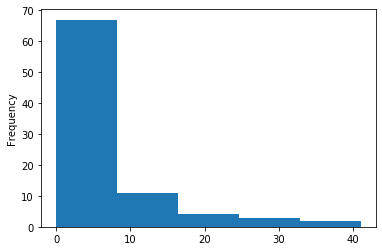

In [24]:
transport_ax = french_venues['Transport_count'].plot.hist(bins = 5 )

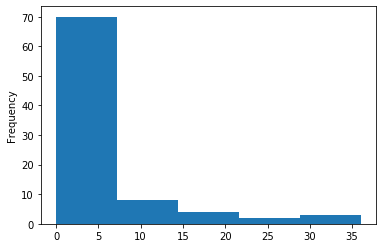

In [25]:
longstay_ax = french_venues['LongStay_count'].plot.hist(bins = 5 )

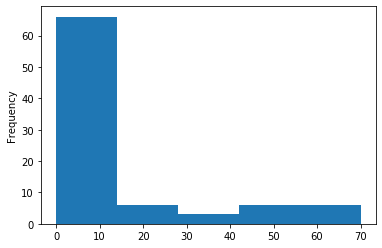

In [26]:
shortstay_ax = french_venues['ShortStay_count'].plot.hist(bins = 5 )

The distribution of food venues is notably different from the distributions of the other kind of venues.

In the case of the other kind of venues, the distribution seems to follow roughly an inverse function (1/x) or maybe a normal distribution.

This is less true for the short stay venues.

In the case of the food venues, the distribution is not as unbalanced. Although the left part is still denser.

In [27]:
#Calculate the average number for each category
avg_food = french_venues['Food_count'].mean()
avg_transport = french_venues['Transport_count'].mean()
avg_longstay = french_venues['LongStay_count'].mean()
avg_shortstay = french_venues['ShortStay_count'].mean()

print('food : {}, transport : {}, long stay : {}, shortstay : {}'.
      format(avg_food, avg_transport, avg_longstay, avg_shortstay))

food : 11.218390804597702, transport : 6.206896551724138, long stay : 5.540229885057471, shortstay : 15.03448275862069


# 5. Application of the model in the case of radius = 150 meters with fixed coefficients

In [28]:
# Calculete the number of venues in the 900 points with radius = 150 meters
nagoya_grid_df = pd.DataFrame(nagoya_grid, columns = ['Part', 'Latitude', 'Longitude', 'x', 'y'])

def count_nearby_venues(df, radius, cat, i, x, y):
    df_temp = (df['x']-x)**2 + (df['y']-y)**2
    df_temp = df_temp < radius**2
    nagoya_grid_df.loc[i, cat + '_count'] = df_temp.sum()
    
def count_nearby_grid(radius):
    for i in nagoya_grid_df.index:
        x = nagoya_grid_df.loc[i,'x']
        y = nagoya_grid_df.loc[i,'y']
        count_nearby_venues(nagoya_venues_food, radius, 'Food', i, x, y)
        count_nearby_venues(nagoya_venues_transport, radius, 'Transport', i, x, y)
        count_nearby_venues(nagoya_venues_longstay, radius, 'LongStay', i, x, y)
        count_nearby_venues(nagoya_venues_shortstay, radius, 'ShortStay', i, x, y)

count_nearby_grid(150)      
nagoya_grid_df

,Part,Latitude,Longitude,x,y,Food_count,Transport_count,LongStay_count,ShortStay_count
0,1,35.097945,136.859624,-5936.621559,-7261.792263,0.0,0.0,0.0,0.0
1,2,35.102447,136.859624,-5936.621559,-6760.979003,0.0,0.0,0.0,0.0
2,3,35.106950,136.859624,-5936.621559,-6260.165744,0.0,0.0,1.0,0.0
3,4,35.111452,136.859624,-5936.621559,-5759.352484,2.0,0.0,1.0,0.0
4,5,35.115955,136.859624,-5936.621559,-5258.539225,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...
895,896,35.210507,136.990196,5936.621559,5258.539225,0.0,0.0,1.0,0.0
896,897,35.215010,136.990196,5936.621559,5759.352484,0.0,0.0,0.0,0.0
897,898,35.219512,136.990196,5936.621559,6260.165744,0.0,0.0,0.0,1.0
898,899,35.224015,136.990196,5936.621559,6760.979003,0.0,0.0,0.0,0.0


In [29]:
# The model is the following
# Dissimilarity = a1 * p_food + a2 * p_transport + a3 * p_longstay + a4 * p_shortstay + a5 * ttcounts
#Prepare the dataframes to the form

def change_variables(df):
    df['Total_count'] = df['Food_count'] + df['Transport_count'] + df['LongStay_count'] + df['ShortStay_count']
    df['P_Food'] = df['Food_count'] / df['Total_count']
    df['P_Transport'] = df['Transport_count'] / df['Total_count']
    df['P_Longstay'] = df['LongStay_count'] / df['Total_count']
    df['P_Shortstay'] = df['ShortStay_count'] / df['Total_count']

change_variables(french_venues)
change_variables(nagoya_grid_df)

nagoya_grid_df

,Part,Latitude,Longitude,x,y,Food_count,Transport_count,LongStay_count,ShortStay_count,Total_count,P_Food,P_Transport,P_Longstay,P_Shortstay
0,1,35.097945,136.859624,-5936.621559,-7261.792263,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2,35.102447,136.859624,-5936.621559,-6760.979003,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,35.106950,136.859624,-5936.621559,-6260.165744,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.000000,0.0
3,4,35.111452,136.859624,-5936.621559,-5759.352484,2.0,0.0,1.0,0.0,3.0,0.666667,0.0,0.333333,0.0
4,5,35.115955,136.859624,-5936.621559,-5258.539225,0.0,0.0,0.0,3.0,3.0,0.000000,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,35.210507,136.990196,5936.621559,5258.539225,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.000000,0.0
896,897,35.215010,136.990196,5936.621559,5759.352484,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
897,898,35.219512,136.990196,5936.621559,6260.165744,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.000000,1.0
898,899,35.224015,136.990196,5936.621559,6760.979003,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [30]:
# Split randomly the French dataset into a training set and a test set
french_venues_rd = french_venues.sample(frac = 1, axis = 0, random_state = 4).reset_index(drop = True)
nb_fr_rest = french_venues_rd.shape[0]
nb_fr_rest_training = int(nb_fr_rest*2/3)
fr_train = french_venues_rd.loc[0:nb_fr_rest_training,:]
fr_test = french_venues_rd.loc[nb_fr_rest_training + 1 :nb_fr_rest,:]

In [31]:
# Preparation of the vector X
# Get rid of all NaN value 
nagoya_grid_df2 = nagoya_grid_df.dropna(axis = 0).reset_index()

In [32]:
x0 = [1,
     1,
     1,
     1,
     0.01]

a1 = x0[0]
a2 = x0[1]
a3 = x0[2]
a4 = x0[3]
a5 = x0[4]

diff_series = pd.DataFrame(nagoya_grid_df2[['Part','P_Food']], columns = ['Part','Diff'])

for i_grid in nagoya_grid_df2.index:

    p_food = nagoya_grid_df2.loc[i_grid,'P_Food']
    p_transport = nagoya_grid_df2.loc[i_grid,'P_Transport']
    p_longstay = nagoya_grid_df2.loc[i_grid,'P_Longstay']
    p_shortstay = nagoya_grid_df2.loc[i_grid,'P_Shortstay']
    total_count = nagoya_grid_df2.loc[i_grid,'Total_count']

    diff = 0

    for i_fr in fr_train.index:
        fr_p_food = fr_train.loc[i_fr,'P_Food']
        fr_p_transport = fr_train.loc[i_fr,'P_Transport']
        fr_p_longstay = fr_train.loc[i_fr,'P_Longstay']
        fr_p_shortstay = fr_train.loc[i_fr,'P_Shortstay']
        fr_total_count = fr_train.loc[i_fr,'Total_count']
        diff += a1 * (p_food - fr_p_food)**2
        diff += a2 * (p_transport - fr_p_transport) **2
        diff += a3 * (p_longstay - fr_p_longstay) **2
        diff += a4 * (p_shortstay - fr_p_shortstay) **2
        diff += a5 * (total_count - fr_total_count) **2
        
    
    diff_series.loc[i_grid, 'Diff'] = diff
    
diff_series.sort_values(by = 'Diff', inplace= True)

In [33]:
nagoya_grid_df2['Has_Fr'] = 0
for i in nagoya_grid_df2.index:
    for j in fr_train.index:
        x_ng = nagoya_grid_df2.loc[i,'x']
        y_ng = nagoya_grid_df2.loc[i,'y']
        x_fr = fr_train.loc[j,'x']
        y_fr = fr_train.loc[j,'y']
        distance = (x_ng - x_fr) ** 2 + (y_ng - y_fr) ** 2
        if distance <= radius_grid ** 2:
            nagoya_grid_df2.loc[i,'Has_Fr'] = 1
            
total_areas_with_fr_rest = nagoya_grid_df2['Has_Fr'].sum()
print(total_areas_with_fr_rest)

64


In [34]:
nagoya_grid_df2['Predict_Fr'] = 0
i = 0
for part in diff_series['Part']:
    ind = nagoya_grid_df2[nagoya_grid_df2['Part'] == part].index[0]
    nagoya_grid_df2.loc[ind,'Predict_Fr'] = 1
    i += 1 
    if i == total_areas_with_fr_rest:
        break
nagoya_grid_df2

,index,Part,Latitude,Longitude,x,y,Food_count,Transport_count,LongStay_count,ShortStay_count,Total_count,P_Food,P_Transport,P_Longstay,P_Shortstay,Has_Fr,Predict_Fr
0,2,3,35.106950,136.859624,-5936.621559,-6260.165744,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0,0
1,3,4,35.111452,136.859624,-5936.621559,-5759.352484,2.0,0.0,1.0,0.0,3.0,0.666667,0.000000,0.333333,0.000000,0,0
2,4,5,35.115955,136.859624,-5936.621559,-5258.539225,0.0,0.0,0.0,3.0,3.0,0.000000,0.000000,0.000000,1.000000,0,0
3,5,6,35.120457,136.859624,-5936.621559,-4757.725965,1.0,0.0,1.0,1.0,3.0,0.333333,0.000000,0.333333,0.333333,0,0
4,6,7,35.124960,136.859624,-5936.621559,-4256.912706,2.0,2.0,3.0,5.0,12.0,0.166667,0.166667,0.250000,0.416667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,891,892,35.192497,136.990196,5936.621559,3255.286187,3.0,1.0,2.0,2.0,8.0,0.375000,0.125000,0.250000,0.250000,0,0
772,893,894,35.201502,136.990196,5936.621559,4256.912706,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,1.000000,0,0
773,894,895,35.206005,136.990196,5936.621559,4757.725965,0.0,2.0,1.0,0.0,3.0,0.000000,0.666667,0.333333,0.000000,0,0
774,895,896,35.210507,136.990196,5936.621559,5258.539225,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0,0


In [35]:
neg_f1_score = -f1_score(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'])
neg_f1_score

# The good score is because there are 67 areas out of 900 where there are French restaurants.

-0.40625

In [36]:
# Let us check the map
#show the French restaurants along with the estimated center
avg_frr_lat = 35.163231
avg_frr_lgt = 136.924910
avg_frr_radius = 6000

# show all French restaurants in Nagoya to map with the circle
map_newyork_venues = folium.Map(location=[nagoya_latitude, nagoya_longitude], zoom_start=10)

# for name, lat, lgt in zip(french_venues['Venue'], french_venues['Venue Latitude'], french_venues['Venue Longitude']):
#     label = '{}'.format(name)
#     label = folium.Popup(label, parse_html=True)
    
#     folium.CircleMarker(
#         [lat, lgt],
#         radius=5,
#         popup=label,
#         color='red',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_newyork_venues) 
folium.Circle([avg_frr_lat, avg_frr_lgt], 
              avg_frr_radius, 
              popup=None, 
              color='red',
              tooltip=None).add_to(map_newyork_venues)

# show the true positives, false positive and so on
for hfr, pfr, lat, lgt in zip(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'], nagoya_grid_df2['Latitude'], nagoya_grid_df2['Longitude']):
    
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    if hfr == 1 and pfr == 1:
        color = 'green'
    elif hfr == 0 and pfr == 0:
        color = 'blue'
    elif hfr == 0 and pfr == 1:
        color = 'red'
    elif hfr == 1 and pfr == 0:
        color = 'yellow'
        
        
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#000000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_venues) 


map_newyork_venues



# 6. Research of the best coefficients for model in the case of radius = 150 meters, using BFGS algorithm 

In [37]:
def calculate_f1_score_model(x):

    a1 = x[0]
    a2 = x[1]
    a3 = x[2]
    a4 = x[3]
    a5 = x[4]
    
    diff_series = pd.DataFrame(nagoya_grid_df2[['Part','P_Food']], columns = ['Part','Diff'])

    for i_grid in nagoya_grid_df2.index:

        p_food = nagoya_grid_df2.loc[i_grid,'P_Food']
        p_transport = nagoya_grid_df2.loc[i_grid,'P_Transport']
        p_longstay = nagoya_grid_df2.loc[i_grid,'P_Longstay']
        p_shortstay = nagoya_grid_df2.loc[i_grid,'P_Shortstay']
        total_count = nagoya_grid_df2.loc[i_grid,'Total_count']

        diff = 0

        for i_fr in fr_train.index:
            fr_p_food = fr_train.loc[i_fr,'P_Food']
            fr_p_transport = fr_train.loc[i_fr,'P_Transport']
            fr_p_longstay = fr_train.loc[i_fr,'P_Longstay']
            fr_p_shortstay = fr_train.loc[i_fr,'P_Shortstay']
            fr_total_count = fr_train.loc[i_fr,'Total_count']
            diff += a1 * (p_food - fr_p_food)**2
            diff += a2 * (p_transport - fr_p_transport) **2
            diff += a3 * (p_longstay - fr_p_longstay) **2
            diff += a4 * (p_shortstay - fr_p_shortstay) **2
            diff += a5 * (total_count - fr_total_count) **2


        diff_series.loc[i_grid, 'Diff'] = diff

    diff_series.sort_values(by = 'Diff', inplace= True)

    nagoya_grid_df2['Predict_Fr'] = 0
    i = 0
    for part in diff_series['Part']:
        ind = nagoya_grid_df2[nagoya_grid_df2['Part'] == part].index[0]
        nagoya_grid_df2.loc[ind,'Predict_Fr'] = 1
        i += 1 
        if i == total_areas_with_fr_rest:
            break

    neg_f1_score = -f1_score(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'])
    
    return neg_f1_score

In [38]:

# res = minimize(calculate_f1_score_model, x0, method='BFGS')
# res
res = least_squares(calculate_f1_score_model, x0)
res

 active_mask: array([0., 0., 0., 0., 0.])
        cost: 0.08251953125
         fun: array([-0.40625])
        grad: array([0., 0., 0., 0., 0.])
         jac: array([[0., 0., 0., 0., 0.]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 1
        njev: 1
  optimality: 0.0
      status: 1
     success: True
           x: array([1.  , 1.  , 1.  , 1.  , 0.01])

In [39]:
neg_f1_score

-0.40625

The optimization algorithm fails to find a better vector. Let's thus end our research here. 

It is certainly possible to find a better model, but considering the scope of this educational project, the results are sufficient.

# 7. Test of the model on the test set

In [40]:
for i in nagoya_grid_df2.index:
    nagoya_grid_df2.loc[i,'Has_Fr'] = 0
    for j in fr_test.index:
        x_ng = nagoya_grid_df2.loc[i,'x']
        y_ng = nagoya_grid_df2.loc[i,'y']
        x_fr = fr_test.loc[j,'x']
        y_fr = fr_test.loc[j,'y']
        distance = (x_ng - x_fr) ** 2 + (y_ng - y_fr) ** 2
        if distance <= radius_grid ** 2:
            nagoya_grid_df2.loc[i,'Has_Fr'] = 1
            
total_areas_with_fr_rest = nagoya_grid_df2['Has_Fr'].sum()
print(total_areas_with_fr_rest)

33


In [41]:
a1 = x0[0]
a2 = x0[1]
a3 = x0[2]
a4 = x0[3]
a5 = x0[4]

diff_series = pd.DataFrame(nagoya_grid_df2[['Part','P_Food']], columns = ['Part','Diff'])

for i_grid in nagoya_grid_df2.index:

    p_food = nagoya_grid_df2.loc[i_grid,'P_Food']
    p_transport = nagoya_grid_df2.loc[i_grid,'P_Transport']
    p_longstay = nagoya_grid_df2.loc[i_grid,'P_Longstay']
    p_shortstay = nagoya_grid_df2.loc[i_grid,'P_Shortstay']
    total_count = nagoya_grid_df2.loc[i_grid,'Total_count']

    diff = 0

    for i_fr in fr_test.index:
        fr_p_food = fr_test.loc[i_fr,'P_Food']
        fr_p_transport = fr_test.loc[i_fr,'P_Transport']
        fr_p_longstay = fr_test.loc[i_fr,'P_Longstay']
        fr_p_shortstay = fr_test.loc[i_fr,'P_Shortstay']
        fr_total_count = fr_test.loc[i_fr,'Total_count']
        diff += a1 * (p_food - fr_p_food)**2
        diff += a2 * (p_transport - fr_p_transport) **2
        diff += a3 * (p_longstay - fr_p_longstay) **2
        diff += a4 * (p_shortstay - fr_p_shortstay) **2
        diff += a5 * (total_count - fr_total_count) **2


    diff_series.loc[i_grid, 'Diff'] = diff

diff_series.sort_values(by = 'Diff', inplace= True)

nagoya_grid_df2['Predict_Fr'] = 0
i = 0
for part in diff_series['Part']:
    ind = nagoya_grid_df2[nagoya_grid_df2['Part'] == part].index[0]
    nagoya_grid_df2.loc[ind,'Predict_Fr'] = 1
    i += 1 
    if i == total_areas_with_fr_rest:
        break

neg_f1_score = -f1_score(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'])

In [42]:
# Let us check the map
#show the French restaurants along with the estimated center
avg_frr_lat = 35.163231
avg_frr_lgt = 136.924910
avg_frr_radius = 6000

# show all French restaurants in Nagoya to map with the circle
map_newyork_venues = folium.Map(location=[nagoya_latitude, nagoya_longitude], zoom_start=10)

folium.Circle([avg_frr_lat, avg_frr_lgt], 
              avg_frr_radius, 
              popup=None, 
              color='red',
              tooltip=None).add_to(map_newyork_venues)

# show the true positives, false positive and so on
for hfr, pfr, lat, lgt in zip(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'], nagoya_grid_df2['Latitude'], nagoya_grid_df2['Longitude']):
    
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    if hfr == 1 and pfr == 1:
        color = 'green'
    elif hfr == 0 and pfr == 0:
        color = 'blue'
    elif hfr == 0 and pfr == 1:
        color = 'red'
    elif hfr == 1 and pfr == 0:
        color = 'yellow'
        
        
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#000000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_venues) 


map_newyork_venues


In [43]:
print("The F1 score of the model on the test set is : ", -neg_f1_score)

The F1 score of the model on the test set is :  0.12121212121212122


# 8. Test of the model on the complete set

In [44]:
for i in nagoya_grid_df2.index:
    nagoya_grid_df2.loc[i,'Has_Fr'] = 0
    for j in french_venues_rd.index:
        x_ng = nagoya_grid_df2.loc[i,'x']
        y_ng = nagoya_grid_df2.loc[i,'y']
        x_fr = french_venues_rd.loc[j,'x']
        y_fr = french_venues_rd.loc[j,'y']
        distance = (x_ng - x_fr) ** 2 + (y_ng - y_fr) ** 2
        if distance <= radius_grid ** 2:
            nagoya_grid_df2.loc[i,'Has_Fr'] = 1
            
total_areas_with_fr_rest = nagoya_grid_df2['Has_Fr'].sum()
print(total_areas_with_fr_rest)

80


In [45]:
a1 = x0[0]
a2 = x0[1]
a3 = x0[2]
a4 = x0[3]
a5 = x0[4]

diff_series = pd.DataFrame(nagoya_grid_df2[['Part','P_Food']], columns = ['Part','Diff'])

for i_grid in nagoya_grid_df2.index:

    p_food = nagoya_grid_df2.loc[i_grid,'P_Food']
    p_transport = nagoya_grid_df2.loc[i_grid,'P_Transport']
    p_longstay = nagoya_grid_df2.loc[i_grid,'P_Longstay']
    p_shortstay = nagoya_grid_df2.loc[i_grid,'P_Shortstay']
    total_count = nagoya_grid_df2.loc[i_grid,'Total_count']

    diff = 0

    for i_fr in french_venues_rd.index:
        fr_p_food = french_venues_rd.loc[i_fr,'P_Food']
        fr_p_transport = french_venues_rd.loc[i_fr,'P_Transport']
        fr_p_longstay = french_venues_rd.loc[i_fr,'P_Longstay']
        fr_p_shortstay = french_venues_rd.loc[i_fr,'P_Shortstay']
        fr_total_count = french_venues_rd.loc[i_fr,'Total_count']
        diff += a1 * (p_food - fr_p_food)**2
        diff += a2 * (p_transport - fr_p_transport) **2
        diff += a3 * (p_longstay - fr_p_longstay) **2
        diff += a4 * (p_shortstay - fr_p_shortstay) **2
        diff += a5 * (total_count - fr_total_count) **2


    diff_series.loc[i_grid, 'Diff'] = diff

diff_series.sort_values(by = 'Diff', inplace= True)

nagoya_grid_df2['Predict_Fr'] = 0
i = 0
for part in diff_series['Part']:
    ind = nagoya_grid_df2[nagoya_grid_df2['Part'] == part].index[0]
    nagoya_grid_df2.loc[ind,'Predict_Fr'] = 1
    i += 1 
    if i == total_areas_with_fr_rest:
        break

neg_f1_score = -f1_score(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'])

In [46]:
# Let us check the map
#show the French restaurants along with the estimated center

# show all French restaurants in Nagoya to map with the circle
map_newyork_venues = folium.Map(location=[nagoya_latitude, nagoya_longitude], zoom_start=10)

nb_true_positive = 0
nb_true_negative = 0
nb_false_positive = 0
nb_false_negative = 0

folium.Circle([avg_frr_lat, avg_frr_lgt], 
              avg_frr_radius, 
              popup=None, 
              color='red',
              tooltip=None).add_to(map_newyork_venues)

# show the true positives, false positive and so on
for hfr, pfr, lat, lgt in zip(nagoya_grid_df2['Has_Fr'], nagoya_grid_df2['Predict_Fr'], nagoya_grid_df2['Latitude'], nagoya_grid_df2['Longitude']):
    
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    if hfr == 1 and pfr == 1:
        color = 'green'
        nb_true_positive += 1 
    elif hfr == 0 and pfr == 0:
        color = 'blue'
        nb_true_negative += 1
    elif hfr == 0 and pfr == 1:
        color = 'red'
        nb_false_positive += 1
    elif hfr == 1 and pfr == 0:
        color = 'yellow'
        nb_false_negative += 1
        
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#000000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_venues) 

    
    

map_newyork_venues

In [47]:
print("The F1 score of the model on the test set is : ", -neg_f1_score)

The F1 score of the model on the test set is :  0.3875


In [48]:
print(nb_true_positive, nb_true_negative, nb_false_positive, nb_false_negative)

31 647 49 49


# 9. Calculation of the average F1 score if the model was random

In [49]:
total_true_restaurants = nb_true_positive + nb_false_negative
total_false_restaurants = nb_true_negative + nb_false_positive
total_areas =  total_true_restaurants + total_false_restaurants
print(total_areas)

776


In [50]:
#calculation of the average f1 score if the model was random
from random import randint

In [51]:
nagoya_grid_df3 = nagoya_grid_df2.copy()
average_f1 = 0
total_areas_with_fr_rest = int(total_areas_with_fr_rest)
for serie in range(0,2000):
    nagoya_grid_df3['Predict_Fr_' + str(serie)] = 0
    for i in range(0,total_areas_with_fr_rest):
        predicted_french = randint(0,nagoya_grid_df3.shape[0]-1)
        nagoya_grid_df3.loc[predicted_french,'Predict_Fr_' + str(serie)] = 1
    f1_score_serie = f1_score(nagoya_grid_df3['Has_Fr'], nagoya_grid_df3['Predict_Fr_' + str(serie)])
    average_f1 += f1_score_serie
print(average_f1 / 2000)

0.10021594893378327


Conclusion: The model is bad, but still far better than random guesses!